## Setup imports

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import json
import time, random
import torch
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from monai.utils import set_determinism, first
from monai.networks.nets import ViTAutoEnc, densenet121, AutoEncoder
from monai.losses import ContrastiveLoss
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandAffined,
    RandFlipd,
    Resized,
)
from src.utils import data_split, ensure_folder_exists
print_config()
# Set Determinism
set_determinism(seed=42)
pretrain_data_path = './data/MedNIST/pretrain_data_dicts.json'
assert os.path.exists(pretrain_data_path), 'Pretrain data not found'
logdir_path = './logs'
ensure_folder_exists(logdir_path)
assert os.path.exists(logdir_path), 'Log directory not found'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/cloudspace/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.15.1
Pillow version: 10.4.0
Tensorboard version: 2.15.1
gdown version: 5.2.0
TorchVision version: 0.17.1+cu121
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 6.1.1
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.19.0
pynrrd version: 1.1.1
clearml version: 1.17.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recom

##### Define file paths & output directory path

In [5]:
with open(pretrain_data_path, "r") as json_f:
    json_data = json.load(json_f)

splited_data = data_split(json_data, [0.8, 0.2])

train_data = splited_data["train"]
val_data = splited_data["val"]

print("Total Number of Training Data Samples: {}".format(len(train_data)))
print(train_data[1])
print("#" * 10)
print("Total Number of Validation Data Samples: {}".format(len(val_data)))
print(val_data[-1])
print("#" * 10)


Train data size:  18864
Validation data size:  4717
Test data size:  0
Total Number of Training Data Samples: 18864
{'image': 'data/MedNIST/CXR/006621.jpeg', 'label': 'CXR'}
##########
Total Number of Validation Data Samples: 4717
{'image': 'data/MedNIST/ChestCT/001226.jpeg', 'label': 'ChestCT'}
##########


##### Define MONAI Transforms 

image shape: torch.Size([64, 64])
image2 shape: torch.Size([64, 64])
gt_image shape: torch.Size([64, 64])


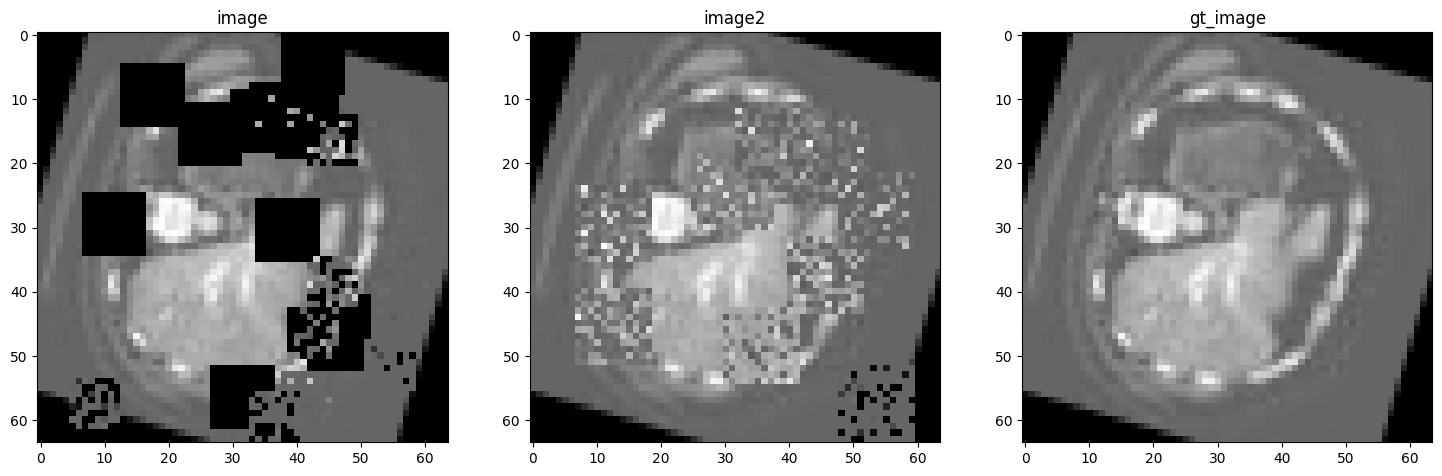

In [6]:
# Define Training Transforms
holes = 10
hole_spatial_size = 10
train_transforms = Compose(
    [
        LoadImaged(keys=["image"], image_only=True),
        EnsureChannelFirstd(keys=["image"]),
        # Spacingd(keys=["image"], pixdim=(2.0, 2.0, 2.0), mode=("bilinear")),
        # ScaleIntensityRanged(
        #     keys=["image"],
        #     a_min=-57,
        #     a_max=164,
        #     b_min=0.0,
        #     b_max=1.0,
        #     clip=True,
        # ),
        # CropForegroundd(keys=["image"], source_key="image"),
        # SpatialPadd(keys=["image"], spatial_size=(96, 96, 96)),
        # RandSpatialCropSamplesd(keys=["image"], roi_size=(96, 96, 96), random_size=False, num_samples=2),
        CopyItemsd(keys=["image"], times=2, names=["gt_image", "image_2"], allow_missing_keys=False),
        RandAffined(
            keys=["image", "image_2", "gt_image"],
            prob=0.8,
            rotate_range=0.5,
            shear_range=0.0,
            translate_range=0.0,
            scale_range=0.0,
            mode=("bilinear", "bilinear", "bilinear"),
            padding_mode="zeros",
        ),
        RandFlipd(keys=["image", "image_2", "gt_image"], prob=0.8, spatial_axis=0),
        RandFlipd(keys=["image", "image_2", "gt_image"], prob=0.8, spatial_axis=1),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=holes, spatial_size=hole_spatial_size, dropout_holes=True, fill_value=0
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=holes, spatial_size=hole_spatial_size, dropout_holes=False, fill_value=0
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        # OneOf(
        #     transforms=[
        #         RandCoarseDropoutd(
        #             keys=["image_2"], prob=1.0, holes=holes, spatial_size=hole_spatial_size, dropout_holes=True, fill_value=0
        #         ),
        #         RandCoarseDropoutd(
        #             keys=["image_2"], prob=1.0, holes=holes, spatial_size=hole_spatial_size, dropout_holes=False, fill_value=0
        #         ),
        #     ]
        # ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8, holes=10, spatial_size=12
                           ),
        
        # Resized(keys=["image", "image_2"], spatial_size=(224, 224, 3), mode=("bilinear", "nearest")),
    ]
)


check_ds = Dataset(data=train_data, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image = check_data["image"][0][0]
image2 = check_data["image_2"][0][0]
gt_image = check_data["gt_image"][0][0]
print(f"image shape: {image.shape}")
print(f"image2 shape: {image2.shape}")
print(f"gt_image shape: {gt_image.shape}")

plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("image2")
plt.imshow(image2, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("gt_image")
plt.imshow(gt_image, cmap="gray")
plt.show()

##### Training Configuration

In [7]:
# Define Network ViT backbone & Loss & Optimizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
model = AutoEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(2, 4, 8),
    strides=(2, 2, 2)
).to(device)
# model = ViTAutoEnc(in_channels=1,
#                    img_size=64,
#                    patch_size=4,
#                    out_channels=1,
#                    spatial_dims=2).to(device)

model.eval()
with torch.no_grad():
    output = model(torch.rand(1, 1, 64, 64).to(device))
    print(output.shape)

Device:  cuda:0
torch.Size([1, 1, 64, 64])


In [ ]:
# Training Config
# Define Hyper-paramters for training loop
max_epochs = 4
val_interval = 1
batch_size = 128
lr = 1e-4

epoch_loss_values = []
step_loss_values = []
epoch_cl_loss_values = []
epoch_recon_loss_values = []
val_loss_values = []
best_val_loss = 1000.0

recon_loss = L1Loss()
contrastive_loss = ContrastiveLoss(temperature=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Define DataLoader using MONAI, CacheDataset needs to be used
train_ds = Dataset(data=train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = Dataset(data=val_data, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4)

##### Training loop with validation

In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_cl_loss = 0
    epoch_recon_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        start_time = time.time()

        inputs, inputs_2, gt_input = (
            batch_data["image"].to(device),
            batch_data["image_2"].to(device),
            batch_data["gt_image"].to(device),
        )
        optimizer.zero_grad()
        outputs_v1 = model(inputs)
        outputs_v2 = model(inputs_2)

        flat_out_v1 = outputs_v1.flatten(start_dim=1, end_dim=-1)
        flat_out_v2 = outputs_v2.flatten(start_dim=1, end_dim=-1)

        r_loss = recon_loss(outputs_v1, gt_input)
        cl_loss = contrastive_loss(flat_out_v1, flat_out_v2)

        # Adjust the CL loss by Recon Loss
        total_loss = r_loss + cl_loss * r_loss

        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        step_loss_values.append(total_loss.item())

        # CL & Recon Loss Storage of Value
        epoch_cl_loss += cl_loss.item()
        epoch_recon_loss += r_loss.item()

        end_time = time.time()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {total_loss.item():.4f}, "
            f"time taken: {end_time-start_time}s"
        )

    epoch_loss /= step
    epoch_cl_loss /= step
    epoch_recon_loss /= step

    epoch_loss_values.append(epoch_loss)
    epoch_cl_loss_values.append(epoch_cl_loss)
    epoch_recon_loss_values.append(epoch_recon_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if epoch % val_interval == 0:
        print("Entering Validation for epoch: {}".format(epoch + 1))
        total_val_loss = 0
        val_step = 0
        model.eval()
        for val_batch in val_loader:
            val_step += 1
            start_time = time.time()
            inputs, gt_input = (
                val_batch["image"].to(device),
                val_batch["gt_image"].to(device),
            )
            # print("Input shape: {}".format(inputs.shape))
            outputs = model(inputs)
            val_loss = recon_loss(outputs, gt_input)
            total_val_loss += val_loss.item()
            end_time = time.time()

        total_val_loss /= val_step
        val_loss_values.append(total_val_loss)
        print(f"epoch {epoch + 1} Validation avg loss: {total_val_loss:.4f}, " f"time taken: {end_time-start_time}s")

        if total_val_loss < best_val_loss:
            print(f"Saving new model based on validation loss {total_val_loss:.4f}")
            best_val_loss = total_val_loss
            checkpoint = {"epoch": max_epochs, "state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(checkpoint, os.path.join(logdir_path, "best_model.pt"))

        plt.figure(1, figsize=(8, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epoch_loss_values)
        plt.grid()
        plt.title("Training Loss")

        plt.subplot(2, 2, 2)
        plt.plot(val_loss_values)
        plt.grid()
        plt.title("Validation Loss")

        plt.subplot(2, 2, 3)
        plt.plot(epoch_cl_loss_values)
        plt.grid()
        plt.title("Training Contrastive Loss")

        plt.subplot(2, 2, 4)
        plt.plot(epoch_recon_loss_values)
        plt.grid()
        plt.title("Training Recon Loss")

        plt.savefig(os.path.join(logdir_path, "loss_plots.png"))
        plt.close(1)

print("Done")

----------
epoch 1/4


1/589, train_loss: 289.6571, time taken: 0.026793718338012695s
2/589, train_loss: 301.6974, time taken: 0.02266216278076172s
3/589, train_loss: 311.2759, time taken: 0.02259659767150879s
4/589, train_loss: 206.9546, time taken: 0.02249431610107422s
5/589, train_loss: 235.5140, time taken: 0.02257370948791504s
6/589, train_loss: 242.9349, time taken: 0.0208284854888916s
7/589, train_loss: 243.8040, time taken: 0.022586345672607422s
8/589, train_loss: 233.7434, time taken: 0.020091533660888672s
9/589, train_loss: 263.6326, time taken: 0.022890090942382812s
10/589, train_loss: 246.9023, time taken: 0.022947311401367188s
11/589, train_loss: 248.4586, time taken: 0.022653818130493164s
12/589, train_loss: 202.3685, time taken: 0.02242898941040039s
13/589, train_loss: 244.6330, time taken: 0.02279067039489746s
14/589, train_loss: 248.4532, time taken: 0.020353317260742188s
15/589, train_loss: 260.2238, time taken: 0.02013683319091797s
16/589, train_loss: 250.7183, time taken: 0.02249741554260